In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from xgboost import XGBClassifier
import xgboost as xgb


#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

random_state = 42

In [3]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148



# **target visualisation**

In [5]:
#response 
target_counts = train_df['Response'].value_counts(normalize=True) * 100

In [6]:
target_counts

Response
0    87.700271
1    12.299729
Name: proportion, dtype: float64

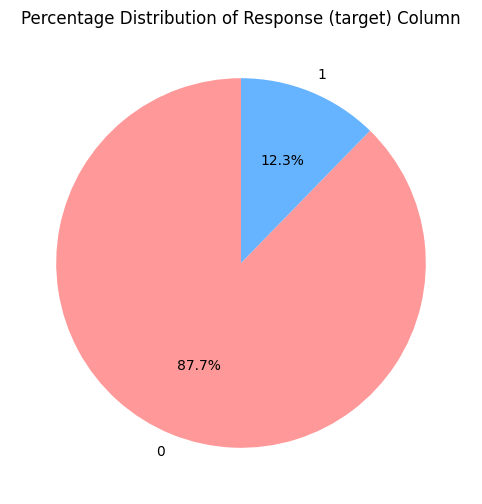

In [7]:
import matplotlib.pyplot as plt

# Plotting a pie chart
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Percentage Distribution of Response (target) Column')
plt.show()

# **Missing Values**

In [8]:
train_df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [9]:
train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,Male,48,1,6.0,0,1-2 Year,Yes,27412.0,26.0,218,0
11504794,11504794,Female,26,1,36.0,0,< 1 Year,Yes,29509.0,152.0,115,1
11504795,11504795,Female,29,1,32.0,1,< 1 Year,No,2630.0,152.0,189,0
11504796,11504796,Female,51,1,28.0,0,1-2 Year,Yes,48443.0,26.0,274,1


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler
le = LabelEncoder()
test_id = test_df["id"]
def cleandata(data):
    data = data.drop(columns = ["id"])
    data["Gender"] =le.fit_transform(data["Gender"]) 
    data["Vehicle_Damage"] = le.fit_transform(data["Vehicle_Damage"])
    experience_mapping = {
    "< 1 Year": 0,
    "1-2 Year": 1,
    "> 2 Years": 2
     }
    data["Vehicle_Age"] =data["Vehicle_Age"].map(experience_mapping) 
    float_cols = data.select_dtypes(include=['float']).columns
    data[float_cols] = data[float_cols].astype(int)
    return data
    
    

In [11]:
train_df = cleandata(train_df)
test_df = cleandata(test_df)

In [12]:
train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,21,1,35,0,1,1,65101,124,187,0
1,1,43,1,28,0,2,1,58911,26,288,1
2,0,25,1,14,1,0,0,38043,152,254,0
3,0,35,1,1,0,1,1,2630,156,76,0
4,0,36,1,15,1,1,0,31951,152,294,0
...,...,...,...,...,...,...,...,...,...,...,...
11504793,1,48,1,6,0,1,1,27412,26,218,0
11504794,0,26,1,36,0,0,1,29509,152,115,1
11504795,0,29,1,32,1,0,0,2630,152,189,0
11504796,0,51,1,28,0,1,1,48443,26,274,1


In [13]:
test_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,20,1,47,0,0,0,2630,160,228
1,1,47,1,28,0,1,1,37483,124,123
2,1,47,1,43,0,1,1,2630,26,271
3,0,22,1,47,1,0,0,24502,152,115
4,1,51,1,19,0,1,0,34115,124,148
...,...,...,...,...,...,...,...,...,...,...
7669861,1,57,1,28,0,1,1,51661,124,109
7669862,1,28,1,50,1,0,0,25651,152,184
7669863,1,47,1,33,1,1,0,2630,138,63
7669864,1,30,1,28,0,0,1,38866,124,119


# **Split Data**

In [14]:
from sklearn.model_selection import train_test_split
X = train_df.drop("Response" , axis = 1)
y = train_df["Response"]
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Scaling data**

In [15]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler
scaler =RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Trying XGBClassifier & GridSearch**

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [10, 5, 20],
    'num_leaves': [31, 62, 127],
}

# Initialize the classifier
XGB_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = RandomizedSearchCV(estimator=XGB_model, param_distributions=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# You can also use the best estimator to make predictions
best_estimator = grid_search.best_estimator_
predictions = best_estimator.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'num_leaves': 127, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.5}
Best Score: 0.8802023677513663


# **Scaling test**

In [17]:
test = scaler.fit_transform(test_df)

# **Prediction**

In [18]:
prediction = best_estimator.predict(test)

In [19]:
prediction

array([0, 0, 0, ..., 0, 1, 0])

# **submission**

In [20]:
output = pd.DataFrame({'id': test_id,
                       'Response': prediction})

output.head()

,id,Response
0,11504798,0
1,11504799,0
2,11504800,0
3,11504801,0
4,11504802,0


In [21]:
output.to_csv("/kaggle/working/submission.csv",index=False)